In [7]:
#from pycocotools.coco import COCO
import glob
import _init_paths
from fast_rcnn.config import cfg
from fast_rcnn.test import im_detect
from fast_rcnn.nms_wrapper import nms
from utils.timer import Timer
import matplotlib.pyplot as plt
import numpy as np
import scipy.io as sio
import caffe, os, sys, cv2
import argparse
from fast_rcnn.config import cfg, cfg_from_file, cfg_from_list
from datasets.config import CLASS_SETS
from datasets.vatic_hierarchy import VaticData, IMDBGroup
import random
from scipy.misc import imread

In [2]:
MAIN_CLASSES = CLASS_SETS['coco']
SUB_CLASSES = CLASS_SETS['vehicle-types']

In [3]:
mapper = {"van":"car", "trailer-head":"truck",\
              "sedan/suv":"car", "scooter":"motorcycle", "bike":"bicycle", "pickup": "car"}  

In [4]:
A = VaticData("van", MAIN_CLASSES, SUB_CLASSES, CLS_mapper=mapper)

Meta data path: /root/data/data-van/meta.json does not exist. Use Default meta data
{'test': {'start': None, 'sets': [1], 'end': None, 'stride': 30}, 'train': {'start': None, 'sets': [0], 'end': None, 'stride': 1}, 'format': 'jpg'}
Total: 4104 images


In [21]:
def show_statistic(imdb, MAIN_CLASSES, SUB_CLASSES):
    
    gts = imdb.gt_roidb()
    statistic = {'length': len(gts), "main":{}, "sub":{} }
   
    
    for gt in gts:
        for i, bbox in enumerate(gt['boxes']):          
            main_cls_idx = gt['gt_classes'][i]
            main_label = MAIN_CLASSES[main_cls_idx]
            statistic["main"][main_label] = statistic["main"].get(main_label, 0 ) + 1
            sub_cls_idx = gt['sub_gt_classes'][i]
            sub_label = SUB_CLASSES[sub_cls_idx]
            statistic["sub"][sub_label] = statistic["sub"].get(sub_label, 0 ) + 1
    return statistic
            



def viz_vaitc_hierarchy(vatic, length, K=5):
    gts = vatic.gt_roidb()
    edgecolor = "green"
    for i in range(K):
        plt.axis('off')

        idx = random.randint(0, length)
        img_path = vatic.image_path_at(idx)
        img = imread(img_path)
        gt = gts[idx]
        fig, ax = plt.subplots(figsize=(6, 6))
        plt.imshow(img)
        
        for i, bbox in enumerate(gt['boxes']):
          
            main_cls_idx = gt['gt_classes'][i]
            main_label = MAIN_CLASSES[main_cls_idx]
            sub_cls_idx = gt['sub_gt_classes'][i]
            sub_label = SUB_CLASSES[sub_cls_idx]
            if sub_label == "not-target" or sub_label == "empty":
                sub_label = ""
                    
            ax.add_patch(
                plt.Rectangle((bbox[0], bbox[1]),
                              bbox[2] - bbox[0],
                              bbox[3] - bbox[1], fill=False,
                              edgecolor=edgecolor, linewidth=3.5)
                )
            ax.text(bbox[0], bbox[1] - 2,
                    '{:s} {:s}'.format(main_label, sub_label),
                    bbox=dict(facecolor='blue', alpha=0.5),
                    fontsize=14, color='white')

       
            
        plt.show()
    

In [22]:



def viz_vaitc(vatic, length, K=5):
    gts = vatic.gt_roidb()
    edgecolor = "green"
    for i in range(K):
        plt.axis('off')

        idx = random.randint(0, length)
        img_path = vatic.image_path_at(idx)
        img = imread(img_path)
        gt = gts[idx]
        fig, ax = plt.subplots(figsize=(6, 6))
        plt.imshow(img)
        
        for i, bbox in enumerate(gt['boxes']):
          
            main_cls_idx = gt['gt_classes'][i]
            main_label = MAIN_CLASSES[main_cls_idx]
            
           
                    
            ax.add_patch(
                plt.Rectangle((bbox[0], bbox[1]),
                              bbox[2] - bbox[0],
                              bbox[3] - bbox[1], fill=False,
                              edgecolor=edgecolor, linewidth=3.5)
                )
            ax.text(bbox[0], bbox[1] - 2,
                    '{:s}'.format(main_label),
                  bbox=dict(facecolor='blue', alpha=0.5),
                    fontsize=14, color='white')

       
            
        plt.show()
    

['coco24',
 'voc',
 'fire',
 'pedestrian',
 'coco',
 'NCTU-vehicles',
 'vehicle-types']

In [6]:
statistic = show_statistic(A, MAIN_CLASSES, SUB_CLASSES)

In [24]:
vatic_names = ["A1HighwayDay", 'B2HighwayNight', "pickup", "tanktruck", "van", "PU_Van", "Sedans_1", "Sedans_2"]
mapper = {"van":"car", "trailer-head":"truck",\
          "sedan/suv":"car", "scooter":"motorcycle", "bike":"bicycle", "pickup": "car"}  
MAIN_CLASSES = CLASS_SETS['coco']
SUB_CLASSES = CLASS_SETS['vehicle-types']
vatics = [VaticData(vatic_name, MAIN_CLASSES,SUB_CLASSES, CLS_mapper=mapper) for vatic_name in vatic_names]
imdb_grop = IMDBGroup(vatics)
imdb_grop.bbox_status()

Meta data path: /root/data/data-A1HighwayDay/meta.json does not exist. Use Default meta data
{'test': {'start': None, 'sets': [1], 'end': None, 'stride': 30}, 'train': {'start': None, 'sets': [0], 'end': None, 'stride': 1}, 'format': 'jpg'}
Total: 3160 images
Meta data path: /root/data/data-B2HighwayNight/meta.json does not exist. Use Default meta data
{'test': {'start': None, 'sets': [1], 'end': None, 'stride': 30}, 'train': {'start': None, 'sets': [0], 'end': None, 'stride': 1}, 'format': 'jpg'}
Total: 3160 images
Meta data path: /root/data/data-pickup/meta.json does not exist. Use Default meta data
{'test': {'start': None, 'sets': [1], 'end': None, 'stride': 30}, 'train': {'start': None, 'sets': [0], 'end': None, 'stride': 1}, 'format': 'jpg'}
Total: 2756 images
Meta data path: /root/data/data-tanktruck/meta.json does not exist. Use Default meta data
{'test': {'start': None, 'sets': [1], 'end': None, 'stride': 30}, 'train': {'start': None, 'sets': [0], 'end': None, 'stride': 1}, 'fo

({u'bicycle': (10, 0.00011523658070017747),
  u'bus': (4376, 0.05042752771439766),
  u'car': (70066, 0.8074166263338635),
  u'motorcycle': (65, 0.0007490377745511535),
  u'person': (4213, 0.04854917144898477),
  'total': 86778,
  u'truck': (8048, 0.09274240014750282)},
 {'pickup': (3717, 0.05304998144606514),
  'sedan/suv': (52527, 0.7496788742043217),
  'total': 70066,
  'van': (13822, 0.1972711443496132)})

In [12]:
VIDEOS = [10, 11, 12, 13, 17, 18, 19, 20, 3, 36, 38, 4, 5 ,6, 7, 8, 9]
vatic_names = ["NCTU_{}.MOV".format(video) for video in VIDEOS]
mapper = {"van":"car", "trailer-head":"truck",\
          "sedan/suv":"car", "scooter":"motorcycle", "bike":"bicycle", "pickup": "car"}  
MAIN_CLASSES = CLASS_SETS['coco']
SUB_CLASSES = CLASS_SETS['vehicle-types']
vatics = [VaticData(vatic_name, MAIN_CLASSES,SUB_CLASSES, CLS_mapper=mapper) for vatic_name in vatic_names]
imdb_grop = IMDBGroup(vatics)
    

Meta data path: /root/data/data-NCTU_10.MOV/meta.json does not exist. Use Default meta data
{'test': {'start': None, 'sets': [1], 'end': None, 'stride': 30}, 'train': {'start': None, 'sets': [0], 'end': None, 'stride': 1}, 'format': 'jpg'}
Total: 3917 images
Meta data path: /root/data/data-NCTU_11.MOV/meta.json does not exist. Use Default meta data
{'test': {'start': None, 'sets': [1], 'end': None, 'stride': 30}, 'train': {'start': None, 'sets': [0], 'end': None, 'stride': 1}, 'format': 'jpg'}
Total: 2009 images
Meta data path: /root/data/data-NCTU_12.MOV/meta.json does not exist. Use Default meta data
{'test': {'start': None, 'sets': [1], 'end': None, 'stride': 30}, 'train': {'start': None, 'sets': [0], 'end': None, 'stride': 1}, 'format': 'jpg'}
Total: 2835 images
Meta data path: /root/data/data-NCTU_13.MOV/meta.json does not exist. Use Default meta data
{'test': {'start': None, 'sets': [1], 'end': None, 'stride': 30}, 'train': {'start': None, 'sets': [0], 'end': None, 'stride': 1}, 

In [13]:
imdb_grop.bbox_status()

({u'car': (136582, 1.0), 'total': 136582},
 {'sedan/suv': (132680, 0.9714310816945132),
  'total': 136582,
  'van': (3902, 0.028568918305486815)})

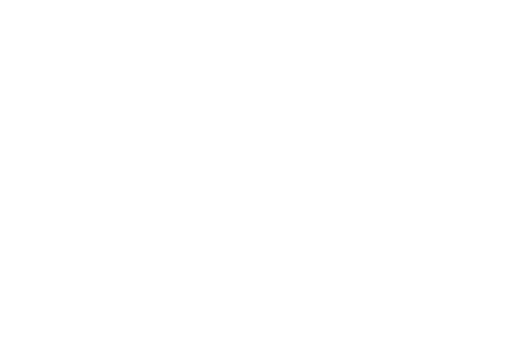

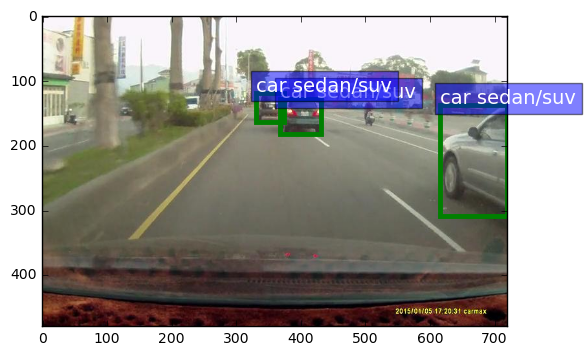

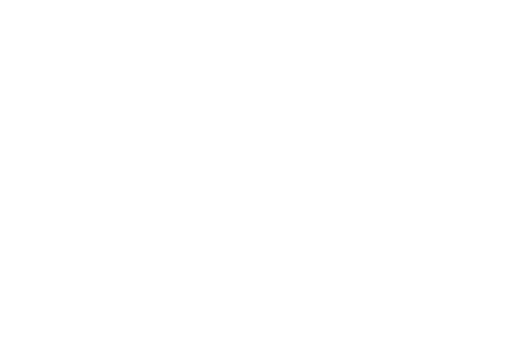

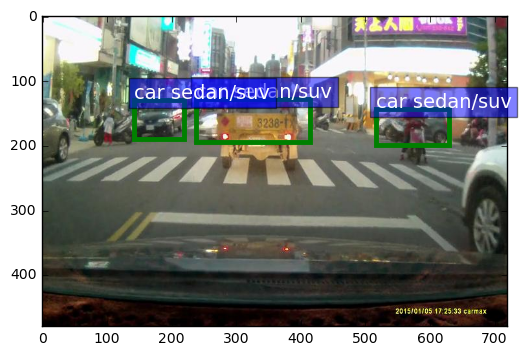

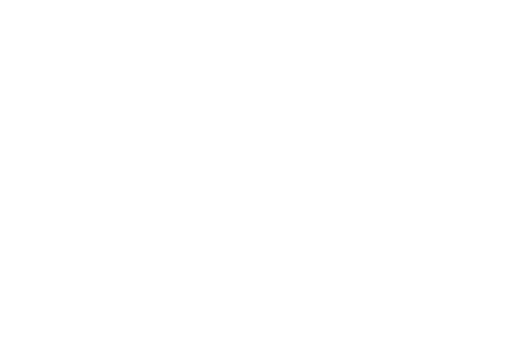

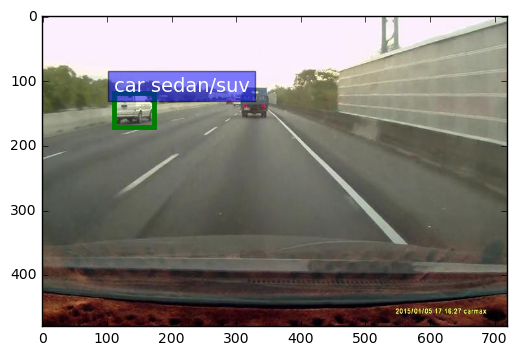

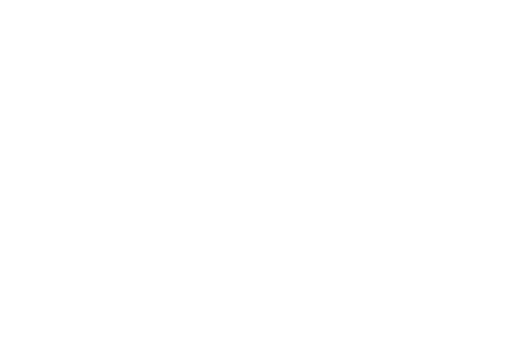

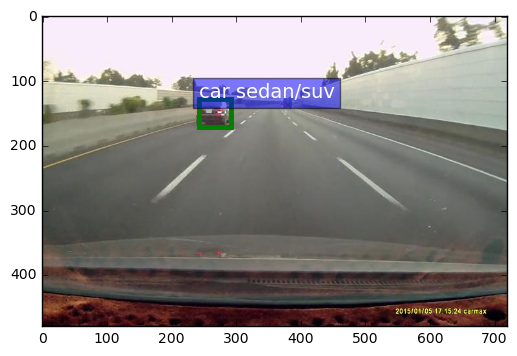

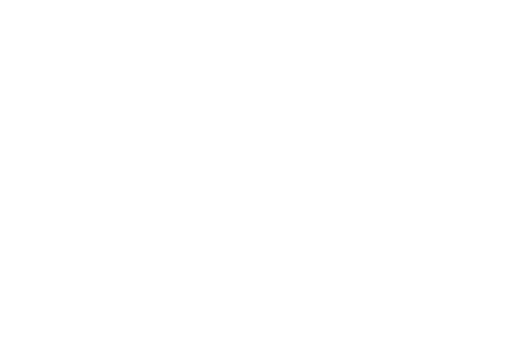

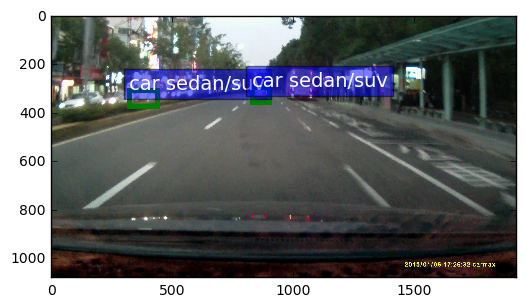

In [23]:
viz_vaitc_hierarchy(imdb_grop, len(imdb_grop.gt_roidb())-1)

Meta data path: /root/data/data-NCTU_36.MOV/meta.json does not exist. Use Default meta data
{'test': {'start': None, 'sets': [1], 'end': None, 'stride': 30}, 'train': {'start': None, 'sets': [0], 'end': None, 'stride': 1}, 'format': 'jpg'}
Total: 1204 images


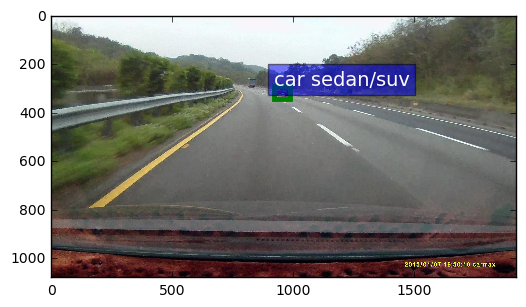

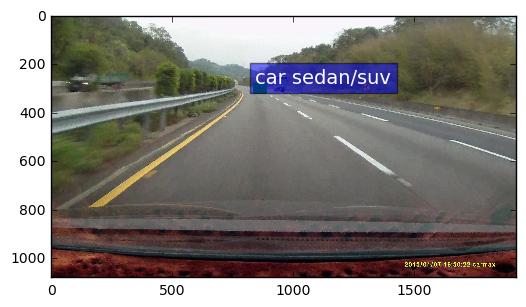

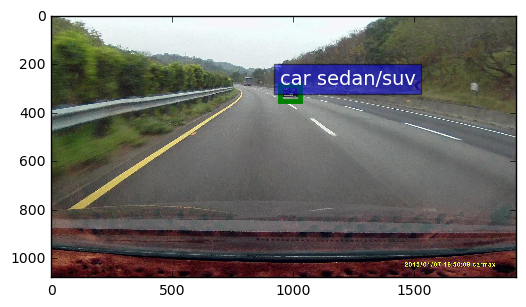

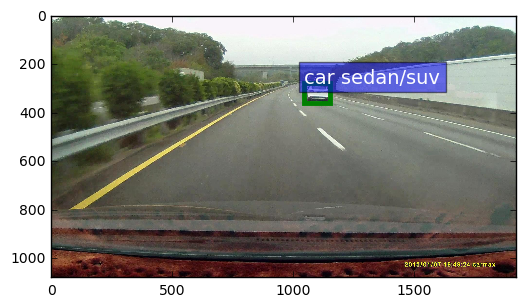

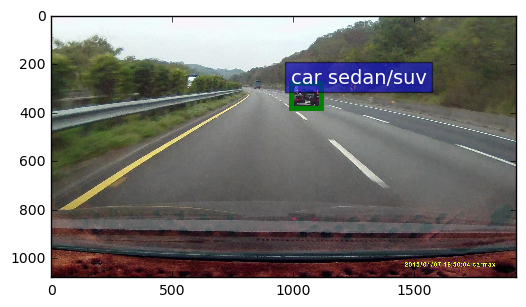

In [11]:
from datasets.vatic_hierarchy import VaticData
mapper = {"van":"car", "trailer-head":"truck",\
              "sedan/suv":"car", "scooter":"motorcycle", "bike":"bicycle", "pickup": "car"}  
MAIN_CLASSES = CLASS_SETS['coco']
SUB_CLASSES = CLASS_SETS['vehicle-types']
vatic = VaticData("NCTU_36.MOV", MAIN_CLASSES,SUB_CLASSES, CLS_mapper=mapper)
viz_vaitc_hierarchy(vatic, len(vatic.gt_roidb())-1)


In [17]:
vatic.bbox_status()

({u'car': (5538, 1.0), 'total': 5538},
 {'sedan/suv': (5538, 1.0), 'total': 5538})

Meta data path: /root/data/data-Sedans_1/meta.json does not exist. Use Default meta data
{'test': {'start': None, 'sets': [1], 'end': None, 'stride': 30}, 'train': {'start': None, 'sets': [0], 'end': None, 'stride': 1}, 'format': 'jpg'}
Total: 3334 images


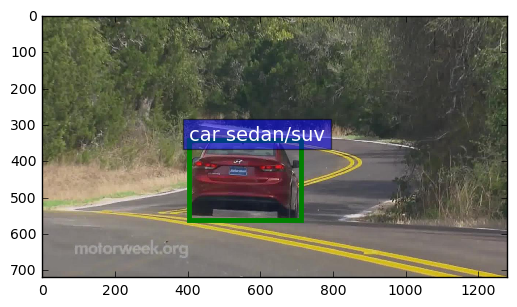

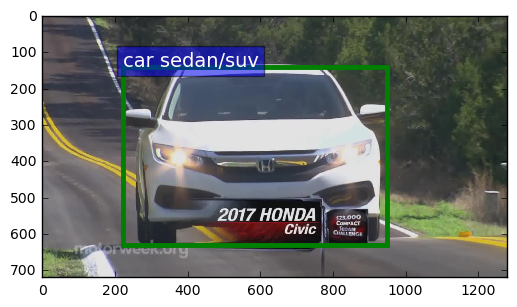

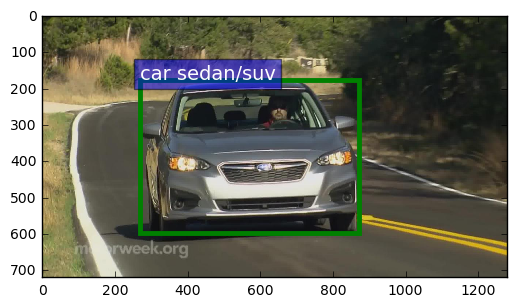

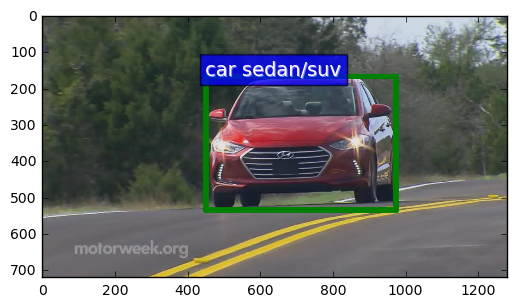

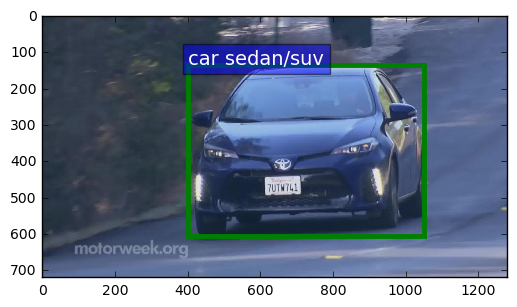

In [15]:
from datasets.vatic_hierarchy import VaticData
mapper = {"van":"car", "trailer-head":"truck",\
              "sedan/suv":"car", "scooter":"motorcycle", "bike":"bicycle", "pickup": "car"}  
MAIN_CLASSES = CLASS_SETS['coco']
SUB_CLASSES = CLASS_SETS['vehicle-types']
vatic = VaticData("Sedans_1", MAIN_CLASSES,SUB_CLASSES, CLS_mapper=mapper)
viz_vaitc_hierarchy(vatic, len(vatic.gt_roidb())-1)

Meta data path: /root/data/data-fire2/meta.json does not exist. Use Default meta data
{'test': {'start': None, 'sets': [1], 'end': None, 'stride': 30}, 'train': {'start': None, 'sets': [0], 'end': None, 'stride': 1}, 'format': 'jpg'}
Total: 4977 images


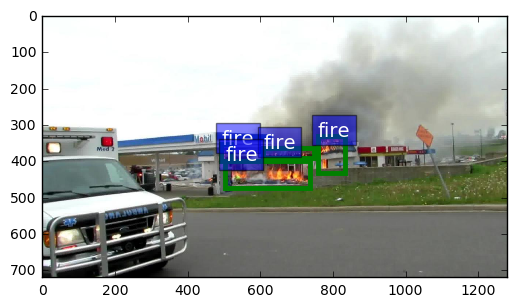

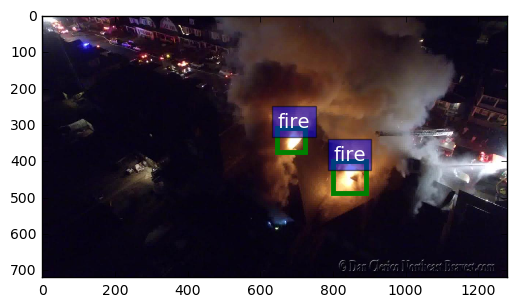

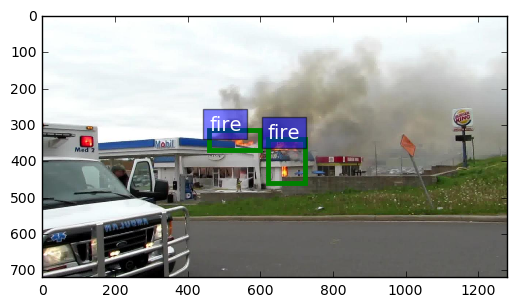

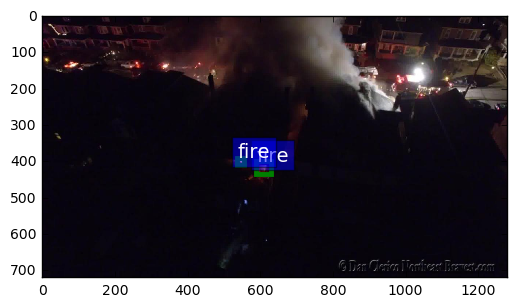

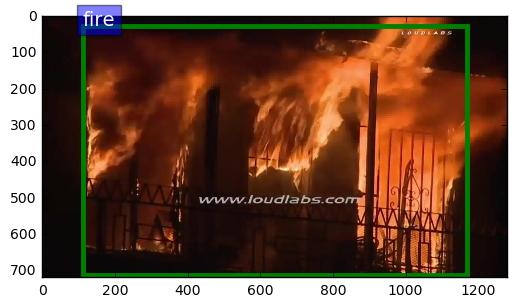

In [7]:
MAIN_CLASSES = CLASS_SETS['fire']
from datasets.vatic import VaticData

CLS_mapper = {}
vatic = VaticData("fire2", MAIN_CLASSES, CLS_mapper=CLS_mapper)
viz_vaitc(vatic, len(vatic.gt_roidb())-1)

Meta data path: /root/data/data-NCTU_3.MOV/meta.json does not exist. Use Default meta data
{'test': {'start': None, 'sets': [1], 'end': None, 'stride': 30}, 'train': {'start': None, 'sets': [0], 'end': None, 'stride': 1}, 'format': 'jpg'}
Total: 3138 images


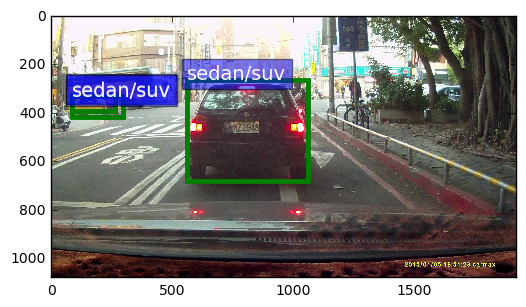

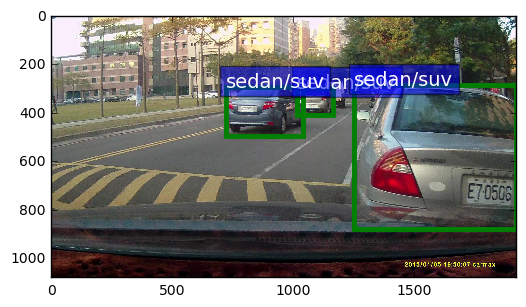

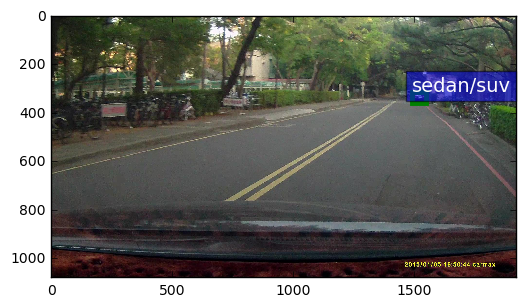

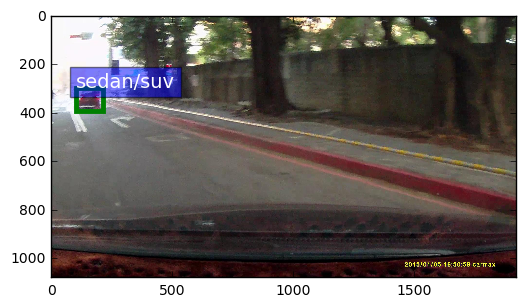

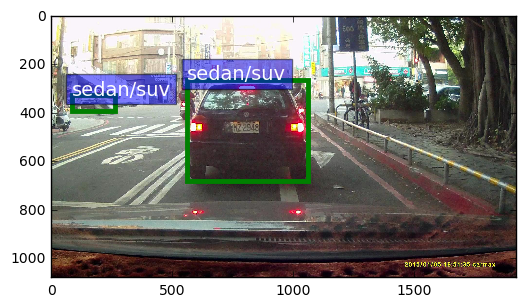

In [12]:
MAIN_CLASSES = CLASS_SETS['NCTU-vehicles']
from datasets.vatic import VaticData

CLS_mapper = {}
vatic = VaticData("NCTU_3.MOV", MAIN_CLASSES, CLS_mapper={})
viz_vaitc(vatic, len(vatic.gt_roidb())-1)ㄣ

In [ ]:
vatic.

{u'0': {u'344': {u'0': {u'attributes': [],
    u'height': 255,
    u'label': u'sedan/suv',
    u'occluded': 0,
    u'outside': 0,
    u'width': 308,
    u'x1': 443,
    u'y1': 258}},
  u'345': {u'0': {u'attributes': [],
    u'height': 255,
    u'label': u'sedan/suv',
    u'occluded': 0,
    u'outside': 0,
    u'width': 310,
    u'x1': 437,
    u'y1': 261}},
  u'346': {u'0': {u'attributes': [],
    u'height': 256,
    u'label': u'sedan/suv',
    u'occluded': 0,
    u'outside': 0,
    u'width': 313,
    u'x1': 430,
    u'y1': 263}},
  u'347': {u'0': {u'attributes': [],
    u'height': 255,
    u'label': u'sedan/suv',
    u'occluded': 0,
    u'outside': 0,
    u'width': 316,
    u'x1': 423,
    u'y1': 266}},
  u'340': {u'0': {u'attributes': [],
    u'height': 253,
    u'label': u'sedan/suv',
    u'occluded': 0,
    u'outside': 0,
    u'width': 298,
    u'x1': 468,
    u'y1': 252}},
  u'341': {u'0': {u'attributes': [],
    u'height': 254,
    u'label': u'sedan/suv',
    u'occluded': 0,
    

In [5]:
a

[]

In [18]:
CLASS_SETS.keys()

['coco24',
 'voc',
 'fire',
 'pedestrian',
 'coco',
 'NCTU-vehicles',
 'vehicle-types']